构建两个神经网络，一个是构建两层的神经网络，一个是构建多层的神经网络，多层神经网络的层数可以自己定义。本次的教程的难度有所提升，但是我会力求深入简出。在这里，我们简单的讲一下难点，本文会提到`LINEAR-> ACTIVATION`转发函数，比如我有一个多层的神经网络，结构是`输入层->隐藏层->隐藏层->···->隐藏层->输出层`，在每一层中，我会首先计算`Z = np.dot(W,A) + b`，这叫做`linear_forward`，然后再计算`A = relu(Z)` 或者 `A = sigmoid(Z)`，这叫做`linear_activation_forward`，合并起来就是这一层的计算方法，所以每一层的计算都有两个步骤，先是计算Z，再计算A

<img src="./picture/img_4.png" width="70%">

步骤：

1. 初始化网络参数

2. 前向传播

    1. 计算一层的中线性求和的部分

    2. 计算激活函数的部分（ReLU使用L-1次，Sigmod使用1次）

    3. 结合线性求和与激活函数

3. 计算误差

4. 反向传播

    1. 线性部分的反向传播公式

    2. 激活函数部分的反向传播公式

    3. 结合线性部分与激活函数的反向传播公式

5. 更新参数

#### 准备软件包

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

np.random.seed(1)

#### 数据加载函数

In [3]:
def load_dataset():

    # 读取训练集
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset['train_set_x'][:]) # 加 [:] 是把数据从 h5py.Dataset 转换为 numpy.ndarray;外层再用 np.array() 是为了确保类型一致（有时是冗余的，但保险）。
    train_set_y_orig = np.array(train_dataset['train_set_y'][:])

    # 读取测试集
    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset['test_set_x'][:])
    test_set_y_orig = np.array(test_dataset['test_set_y'][:])

    # 获取类别标签
    classes = np.array(test_dataset['list_classes'][:])

    # 标签 reshape 处理
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0])) # 原始标签形状是 (m,)，现在 reshape 成 (1, m)，很多神经网络实现中要求标签是形如 (1, m) 的二维数组
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    # 返回所有数据
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

#### 常见激活函数

In [4]:
def sigmoid(Z):
    """
    实现 Sigmoid 激活函数（用 NumPy 实现）

    Arguments:
    Z -- 任意形状的 numpy 数组

    Returns:
    A -- sigmoid(Z) 的输出，形状与 Z 相同
    cache -- 返回 Z，用于反向传播时使用
    """
    A = 1/(1+np.exp(-Z))
    cache = Z

    return A, cache

def sigmoid_backward(dA, cache):
    """
    实现单个 Sigmoid 单元的反向传播

    Arguments:
    dA -- 激活后的梯度，任意形状

    cache -- 前向传播时保存的 Z，用于高效地计算反向传播

    Returns:
    dZ -- 成本对 Z 的梯度
    """
    Z = cache

    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)

    assert (dZ.shape == Z.shape)

    return dZ

def relu(Z):
    """
    实现 ReLU 激活函数

    Arguments:
    Z -- 线性层的输出，任意形状

    Returns:
    A -- 激活后的输出，形状与 Z 相同

    cache -- 一个包含 Z 的变量，用于高效地进行反向传播计算
    """
    A = np.maximum(0,Z)

    assert(A.shape == Z.shape)

    cache = Z
    return A, cache

def relu_backward(dA, cache):
    """
    实现单个 ReLU 单元的反向传播

    Arguments:
    dA -- 激活后的梯度，任意形状

    cache -- 前向传播时保存的 Z，用于高效地计算反向传播

    Returns:
    dZ -- 成本对 Z 的梯度
    """

    Z = cache
    dZ = np.array(dA, copy=True) 

    dZ[Z <= 0] = 0

    assert (dZ.shape == Z.shape)

    return dZ


- testCases：提供了一些测试示例来评估函数的正确性，参见下载的资料或者在底部查看它的代码。

每个函数都用来模拟某个阶段的输入和输出，以便你在实现具体算法时可以用这些数据来验证自己代码是否正确。

In [19]:
# 构造用于测试线性前向传播的输入：输入激活值 A、权重矩阵 W 和偏置项 b。
def linear_forward_test_case():
    np.random.seed(1)
    A_prev = np.random.randn(3,2) # 随机生成一个 3x2 的矩阵 A （前一层）
    W = np.random.randn(1,3) # 随机生成一个 1x3 的矩阵 W （当前层）
    b = np.random.randn(1,1) # 随机生成一个 1x1 的矩阵 b （当前层）

    return A_prev,W,b

# 构造用于测试“线性计算+激活函数”的输入参数·
def linear_activation_forward_test_case():
    # 前一层：三个神经元，当前层：一个神经元
    np.random.seed(2)
    A_prev = np.random.randn(3,2)
    W = np.random.randn(1,3)
    b = np.random.randn(1,1)

    return A_prev, W, b

# 生成一个 2 层神经网络的参数和输入 X，用于测试整个 L 层前向传播函数。
def L_model_forward_test_case():
    np.random.seed(1)
    X = np.random.randn(4,2)
    W1 = np.random.randn(3,4)
    b1 = np.random.randn(3,1)
    W2 = np.random.randn(1,3)
    b2 = np.random.randn(1,1)

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return X, parameters

# 生成用于测试损失函数（交叉熵）计算的预测值 aL 和真实标签 Y。
def compute_cost_test_case():
    Y = np.array([[1, 1, 1]]) # 三个样本的真实标签，全是1
    aL = np.array([[.8, .9, 0.4]]) # 三个样本的预测值，也叫“激活值”，是神经网络的输出

    return Y, aL

# 用于测试线性部分的反向传播函数。
def linear_backward_test_case():
    np.random.seed(1)
    dZ = np.random.randn(1,2)
    A = np.random.randn(3,2)
    W = np.random.randn(1,3)
    b = np.random.randn(1,1)

    linear_cache = (A, W, b)

    return dZ, linear_cache

# 用于测试带激活函数的反向传播。
def linear_activation_backward_test_case():
    np.random.seed(2)
    dA = np.random.randn(1,2) # 当前层的激活梯度 dA，1x2
    A = np.random.randn(3,2) # 前一层的激活值，3x2
    W = np.random.randn(1,3) # 权重矩阵，1x3
    b = np.random.randn(1,1) # 偏置项，1x1
    Z = np.dot(W, A) + b # 当前层的 Z（线性输出）

    activation_cache = (Z) # 激活函数缓存

    linear_cache = (A, W, b) # 前向传播缓存
    linear_activation_cache = (linear_cache, activation_cache) # 合并缓存

    return dA, linear_activation_cache

# 生成完整神经网络的反向传播输入，包括前一层和后一层的 cache。
def L_model_backward_test_case():
    np.random.seed(3)
    AL = np.random.randn(1,2) # 最后一层的输出预测值
    Y = np.array([[1, 0]]) # 真实标签，只有两个样本

    A1 = np.random.randn(4,2)
    W1 = np.random.randn(3,4)
    b1 = np.random.randn(3,1)
    Z1 = np.random.randn(3,2)
    linear_cache_activation_1 = ((A1, W1, b1), Z1) # 第一层缓存

    A2 = np.random.randn(3, 2)
    W2 = np.random.randn(1, 3)
    b2 = np.random.randn(1, 1)
    Z2 = np.random.randn(1, 2)
    linear_cache_activation_2 = ((A2, W2, b2), Z2) # 第二层缓存

    caches = (linear_cache_activation_1, linear_cache_activation_2)

    return AL, Y, caches

# 生成测试用的参数和梯度，用于测试参数更新函数。
def update_parameters_test_case():
    np.random.seed(2)
    W1 = np.random.randn(3,4)
    b1 = np.random.randn(3,1)
    W2 = np.random.randn(1,3)
    b2 = np.random.randn(1,1)

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    np.random.seed(3)
    dW1 = np.random.randn(3,4)
    db1 = np.random.randn(3,1)
    dW2 = np.random.randn(1,3)
    db2 = np.random.randn(1,1)

    grads = {
        "dW1": dW1,
        "db1": db1,
        "dW2": dW2,
        "db2": db2
    }

    return parameters, grads

## 初始化参数
### （1）对于一个两层的神经网络结构而言，模型结构是线性->ReLU->线性->sigmod函数。

In [10]:
def initialize_parameters(n_x, n_h, n_y):
    """
    此函数是为了初始化两层网络参数而使用的函数。
    参数：
        n_x - 输入层节点数量
        n_h - 隐藏层节点数量
        n_y - 输出层节点数量

    返回：
        parameters - 包含你的参数的python字典：
            W1 - 权重矩阵,维度为（n_h，n_x）
            b1 - 偏向量，维度为（n_h，1）
            W2 - 权重矩阵，维度为（n_y，n_h）
            b2 - 偏向量，维度为（n_y，1）

    """
    W1 = np.random.randn(n_h, n_x) * 0.01
    W2 = np.random.randn(n_y, n_h) * 0.01
    b1 = np.random.randn(n_h, 1)
    b2 = np.random.randn(n_y, 1)

    parameters = {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2
    }

    return parameters

# 测试
parameters = initialize_parameters(3,2,1)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))


W1 = [[ 0.01462108 -0.02060141 -0.00322417]
 [-0.00384054  0.01133769 -0.01099891]]
b1 = [[0.04221375]
 [0.58281521]]
W2 = [[-0.00172428 -0.00877858]]
b2 = [[-1.10061918]]


### （2）初始化多层网络参数

In [11]:
def initialize_parameters_deep(layer_dims):
    """
    此函数是为了初始化多层网络参数而使用的函数。
    参数：
        layers_dims - 包含我们网络中每个图层的节点数量的列表

    返回：
        parameters - 包含参数“W1”，“b1”，...，“WL”，“bL”的字典：
                     W1 - 权重矩阵，维度为（layers_dims [1]，layers_dims [1-1]）
                     bl - 偏向量，维度为（layers_dims [1]，1）
    """
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)
    for l in range(1, L): # 输入层定义为0层，故从1开始
        parameters["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) # Xavier 初始化, 缓解梯度爆炸和梯度消失
        parameters["b" + str(l)] = np.zeros((layer_dims[l], 1))

        # 断言
        assert(parameters["W" + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters["b" + str(l)].shape == (layer_dims[l], 1))

    return parameters

# 测试
layer_dims = [5,4,3,2]
print(len(layer_dims))
parameters = initialize_parameters_deep(layer_dims)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))
print("W3 = " + str(parameters["W3"]))
print("b3 = " + str(parameters["b3"]))

4
W1 = [[ 0.79989897  0.19521314  0.04315498 -0.83337927 -0.12405178]
 [-0.15865304 -0.03700312 -0.28040323 -0.01959608 -0.21341839]
 [-0.58757818  0.39561516  0.39413741  0.76454432  0.02237573]
 [-0.18097724 -0.24389238 -0.69160568  0.43932807 -0.49241241]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.59252326 -0.10282495  0.74307418  0.11835813]
 [-0.51189257 -0.3564966   0.31262248 -0.08025668]
 [-0.38441818 -0.11501536  0.37252813  0.98805539]]
b2 = [[0.]
 [0.]
 [0.]]
W3 = [[-0.71829494 -0.36166197 -0.46405457]
 [-1.39665832 -0.53335157 -0.59113495]]
b3 = [[0.]
 [0.]]


- 我们分别构建了两层和多层神经网络的初始化参数的函数，现在我们开始构建前向传播函数。

## 前向传播函数
前向传播有以下三个步骤:

1. LINEAR
2. LINEAR - >ACTIVATION，其中激活函数将会使用ReLU或Sigmoid。
3. [LINEAR - > RELU] ×（L-1） - > LINEAR - > SIGMOID（整个模型）

线性正向传播模块（向量化所有示例）使用公式(3)进行计算：

<img src="./picture/img_5.png" width="30%">


反向传播流程：
前向： Z1 = W1·X + b1 → A1 = relu(Z1) → Z2 = W2·A1 + b2 → A2 = sigmoid(Z2)

反向：

       dA2 → dZ2 = dA2 × sigmoid'(Z2)
           ↓
       dW2, db2, dA1 = linear_backward(dZ2)
           ↓
       dZ1 = dA1 × relu'(Z1)
           ↓
       dW1, db1 = linear_backward(dZ1)


### 线性部分【LINEAR】
前向传播中，线性部分计算如下：

In [13]:
def linear_forword(A_prev, W, b):
    """
    实现前向传播的线性部分。

    参数：
        A_prev - 来自上一层（或输入数据）的激活，维度为(上一层的节点数量，示例的数量）
        W - 权重矩阵，numpy数组，维度为（当前层的节点数量，前一层的节点数量）
        b - 偏向量，numpy向量，维度为（当前层节点数量，1）

    返回：
         Z - 激活功能的输入，也称为预激活参数
         cache - 一个包含“A”，“W”和“b”的字典，存储这些变量以有效地计算后向传递
    """
    Z = np.dot(W, A_prev) + b
    assert (Z.shape == (W.shape[0], A_prev.shape[1]))

    cache = (A_prev, W, b)

    return Z, cache

# 测试
A_prev, W, b = linear_forward_test_case()
Z, linear_cache = linear_forword(A_prev, W, b)
print("Z = " + str(Z))
print("linear_cache = " + str(linear_cache))


Z = [[ 3.26295337 -1.23429987]]
linear_cache = (array([[ 1.62434536, -0.61175641],
       [-0.52817175, -1.07296862],
       [ 0.86540763, -2.3015387 ]]), array([[ 1.74481176, -0.7612069 ,  0.3190391 ]]), array([[-0.24937038]]))


前向传播的单层计算完成了一半啦！我们来开始构建后半部分

### 线性激活部分【LINEAR - >ACTIVATION】
为了更方便，我们将把两个功能（线性和激活）分组为一个功能（LINEAR-> ACTIVATION）。 因此，我们将实现一个执行LINEAR前进步骤，然后执行ACTIVATION前进步骤的功能。我们来看看这激活函数的数学实现吧~

<img src="./picture/img_6.png" width="100%">

In [14]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    实现LINEAR-> ACTIVATION 这一层的前向传播
    实现一次完整的“前向传播”过程：线性计算 + 激活函数

    参数：
        A_prev - 来自上一层（或输入层）的激活，维度为(上一层的节点数量，示例数）
        W - 权重矩阵，numpy数组，维度为（当前层的节点数量，前一层的大小）
        b - 偏向量，numpy阵列，维度为（当前层的节点数量，1）
        activation - 选择在此层中使用的激活函数名，字符串类型，【"sigmoid" | "relu"】

    返回：
        A - 激活函数的输出，也称为激活后的值
        cache - 一个包含“linear_cache”和“activation_cache”的字典，我们需要存储它以有效地计算后向传递
    """
    if activation == "sigmoid":
        Z, linear_cache = linear_forword(A_prev, W, b) # 拿到上一层的Z以及当前层的权重和偏置
        A, activation_cache = sigmoid(Z) # 保存当前层的激活值A以及用于反向传播的Z值
    elif activation == "relu":
        Z, linear_cache = linear_forword(A_prev, W, b)
        A, activation_cache = relu(Z)

    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache) # 保存W, b, Z

    return A, cache

# 测试
A_prev, W, b = linear_activation_forward_test_case()

A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation = "sigmoid")
print("With sigmoid: A = " + str(A))
print("A.shape:" + str(A.shape))
print(linear_activation_cache)

A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation = "relu")
print("With ReLU: A = " + str(A))

With sigmoid: A = [[0.96890023 0.11013289]]
A.shape:(1, 2)
((array([[-0.41675785, -0.05626683],
       [-2.1361961 ,  1.64027081],
       [-1.79343559, -0.84174737]]), array([[ 0.50288142, -1.24528809, -1.05795222]]), array([[-0.90900761]])), array([[ 3.43896131, -2.08938436]]))
With ReLU: A = [[3.43896131 0.        ]]


## 多层网络的前向传播
调用上面的那两个函数来实现，为了在实现L层神经网络时更加方便，我们需要一个函数来复制前一个函数（带有RELU的linear_activation_forward）L-1次，然后用一个带有SIGMOID的linear_activation_forward跟踪它，我们来看一下它的结构是怎样的：
<img src="./picture/img_7.png" width="100%">

#### 直观理解：
- 整个函数从输入层开始，一层一层计算 Z 和 A，除了最后一层使用 sigmoid，其余使用 relu。

- 这些 A 最终传递到输出层，形成预测结果 AL。

- 同时把每层的中间数据都保存下来，反向传播时就能用它们计算梯度了。

In [15]:
def L_model_forward(X, parameters):
    """
    实现[LINEAR-> RELU] *（L-1） - > LINEAR-> SIGMOID计算前向传播，也就是多层网络的前向传播，为后面每一层都执行LINEAR和ACTIVATION

    参数：
        X - 数据，numpy数组，维度为（输入节点数量，示例数）
        parameters - initialize_parameters_deep（）的输出

    返回：
        AL - 最后的激活值
        caches - 包含以下内容的缓存列表：
                 linear_relu_forward（）的每个cache（有L-1个，索引为从0到L-2）
                 linear_sigmoid_forward（）的cache（只有一个，索引为L-1）
    """
    caches = []

    A = X
    L = len(parameters) // 2 # 由于每一层都有 W 和 b，所以参数字典长度是 2L，除以 2 即为总层数。

    # 前向传播：[LINEAR -> RELU]*(L-1)
    for l in range(1, L): # 循环从第1层到第 L-1 层
        A_prev = A # 保存上一层的激活值
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu") # 拿到当前层的激活值和缓存
        caches.append(cache) # 把每层的中间值（Z、A、W、b）保存下来，方便反向传播使用。

    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid") # AL为最后一层的激活值，即A^[L]，cache为当前层的缓存
    caches.append(cache)

    # 断言
    assert (AL.shape == (1, X.shape[1]))

    return AL, caches

# 测试
X, parameters = L_model_forward_test_case()
AL, caches = L_model_forward(X, parameters)
print("AL = " + str(AL))
print("caches = " + str(caches))


AL = [[0.17007265 0.2524272 ]]
caches = [((array([[ 1.62434536, -0.61175641],
       [-0.52817175, -1.07296862],
       [ 0.86540763, -2.3015387 ],
       [ 1.74481176, -0.7612069 ]]), array([[ 0.3190391 , -0.24937038,  1.46210794, -2.06014071],
       [-0.3224172 , -0.38405435,  1.13376944, -1.09989127],
       [-0.17242821, -0.87785842,  0.04221375,  0.58281521]]), array([[-1.10061918],
       [ 1.14472371],
       [ 0.90159072]])), array([[-2.77991749, -2.82513147],
       [-0.11407702, -0.01812665],
       [ 2.13860272,  1.40818979]])), ((array([[0.        , 0.        ],
       [0.        , 0.        ],
       [2.13860272, 1.40818979]]), array([[ 0.50249434,  0.90085595, -0.68372786]]), array([[-0.12289023]])), array([[-1.58511248, -1.08570881]]))]


## 计算成本

In [16]:
def compute_cost(AL, Y):
    """
    实施成本函数。

    参数：
        AL - 与标签预测相对应的概率向量，维度为（1，示例数量）
        Y - 标签向量（例如：如果不是猫，则为0，如果是猫则为1），维度为（1，数量）

    返回：
        cost - 交叉熵成本
    """
    m = Y.shape[1]
    cost = -np.sum(np.multiply(np.log(AL), Y) + np.multiply(np.log(1 - AL), 1 - Y)) / m

    cost = np.squeeze(cost)
    assert(cost.shape == ())

    return cost

# 测试
Y, AL = compute_cost_test_case()
cost = compute_cost(AL, Y)
print("cost = " + str(cost))

cost = 0.414931599615397


## 反向传播
如图：

<img src="./picture/img_8.png" width="100%">

对于线性的部分公式：

<img src="./picture/img_9.png" width="100%">



<img src="./picture/img_10.png" width="100%">



与前向传播类似，我们有需要使用三个步骤来构建反向传播：

1. LINEAR 后向计算
2. LINEAR -> ACTIVATION 后向计算，其中ACTIVATION 计算Relu或者Sigmoid 的结果
3. [LINEAR -> RELU] ×  (L-1) -> LINEAR -> SIGMOID 后向计算 (整个模型)


## 反向传播

In [17]:
# backward-线性部分
def linear_backward(dZ, cache):
    """
    为单层实现反向传播的线性部分（第L层）

    参数：
         dZ - 相对于（当前第l层的）线性输出的成本梯度
         cache - 来自当前层前向传播的值的元组（A_prev，W，b）

    返回：
         dA_prev - 相对于激活（前一层l-1）的成本梯度，与A_prev维度相同
         dW - 相对于W（当前层l）的成本梯度，与W的维度相同
         db - 相对于b（当前层l）的成本梯度，与b维度相同
    """
    A_prev, W, b = cache # 该cache来自于linear_forward()函数
    m = A_prev.shape[1]
    dW = np.dot(dZ, A_prev.T) / m
    db = np.sum(dZ, axis = 1, keepdims = True) / m
    dA_prev = np.dot(W.T, dZ)

    # 断言
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)

    return dA_prev, dW, db

# 测试
dZ, linear_cache = linear_backward_test_case()

dA_prev, dW, db = linear_backward(dZ, linear_cache)
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db))

dA_prev = [[ 0.51822968 -0.19517421]
 [-0.40506361  0.15255393]
 [ 2.37496825 -0.89445391]]
dW = [[-0.10076895  1.40685096  1.64992505]]
db = [[0.50629448]]


### backward-线性激活部分【LINEAR -> ACTIVATION backward】
为了实现linear_activation_backward，提供了两个后向函数
- sigmoid_backward：对于sigmoid的激活函数
`dZ = sigmoid_backward(dA, activation_cache)`
- relu_backward：对于relu的激活函数
`dZ = relu_backward(dA, activation_cache)`

如果 g ( . )是激活函数, 那么`sigmoid_backward` 和 `relu_backward` 这样计算：

<img src="./picture/img_11.png" width="60%">


In [20]:
def linear_activation_backward(dA, cache, activation):
    """
    实现LINEAR-> ACTIVATION层的后向传播。

    参数：
         dA - 当前层l的激活后的梯度值
         cache - 我们存储的用于有效计算反向传播的值的元组（值为linear_cache，activation_cache）
         activation - 要在此层中使用的激活函数名，字符串类型，【"sigmoid" | "relu"】
    返回：
         dA_prev - 相对于激活（前一层l-1）的成本梯度值，与A_prev维度相同
         dW - 相对于W（当前层l）的成本梯度值，与W的维度相同
         db - 相对于b（当前层l）的成本梯度值，与b的维度相同
    """
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

# 测试
dA, linear_activation_cache = linear_activation_backward_test_case()

dA_prev, dW, db = linear_activation_backward(dA, linear_activation_cache, activation = "sigmoid")
print ("sigmoid:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db))

dA_prev, dW, db = linear_activation_backward(dA, linear_activation_cache, activation = "relu")
print ("relu:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db))

sigmoid:
dA_prev = [[ 0.00068794  0.01347576]
 [ 0.00059109  0.01157856]
 [-0.00035859 -0.00702419]]
dW = [[-0.00975201  0.00594401  0.00776748]]
db = [[-0.00669392]]
relu:
dA_prev = [[ 0.44090989  0.05952761]
 [ 0.37883606  0.05114697]
 [-0.2298228  -0.03102857]]
dW = [[ 0.39899183  0.3973954  -0.06975568]]
db = [[-0.23651234]]


已经把两层模型的后向计算完成了，对于多层模型也需要这两个函数来完成，看一下流程图：

<img src="./picture/img_12.png" width="80%">

之前的前向计算中，存储了一些包含包含（X，W，b和Z）的cache，将会使用它们来计算梯度值，所以，在L层模型中，需要从L层遍历所有的隐藏层，在每一步中，我们需要使用那一层的cache值来进行反向传播。

上面我们提到了A [ L ] ，它属于输出层，A [ L ] = σ ( Z [ L ] ) ，所以我们需要计算dAL，我们可以使用下面的代码来计算它：

`dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))`

 计算完了以后，我们可以使用此激活后的梯度dAL继续向后计算，开始构建多层模型向后传播函数：


In [45]:
def L_model_backward(AL, Y, caches):
    """
    对[LINEAR-> RELU] *（L-1） - > LINEAR - > SIGMOID组执行反向传播，就是多层网络的向后传播

    参数：
     AL - 概率向量，正向传播的输出（L_model_forward（））
     Y - 标签向量（例如：如果不是猫，则为0，如果是猫则为1），维度为（1，数量）
     caches - 包含以下内容的cache列表：
                 linear_activation_forward（"relu"）的cache，不包含输出层
                 linear_activation_forward（"sigmoid"）的cache

    返回：
     grads - 具有梯度值的字典
              grads [“dA”+ str（l）] = ...
              grads [“dW”+ str（l）] = ...
              grads [“db”+ str（l）] = ...
    """
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")

    for l in reversed(range(L-1)): # 反向遍历
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, activation = "relu")

        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

# 测试
AL, Y_assess, caches = L_model_backward_test_case()
grads = L_model_backward(AL, Y_assess, caches)
print("dW1 = " + str(grads["dW1"]))
print("db1 = " + str(grads["db1"]))
print("dA1 = " + str(grads["dA1"]))

dW1 = [[0.41010002 0.07807203 0.13798444 0.10502167]
 [0.         0.         0.         0.        ]
 [0.05283652 0.01005865 0.01777766 0.0135308 ]]
db1 = [[-0.22007063]
 [ 0.        ]
 [-0.02835349]]
dA1 = [[ 0.          0.52257901]
 [ 0.         -0.3269206 ]
 [ 0.         -0.32070404]
 [ 0.         -0.74079187]]


## 更新参数

In [22]:
def update_parameters(parameters, grads, learning_rate):
    """
    使用梯度下降更新参数

    参数：
     parameters - 包含你的参数的字典
     grads - 包含梯度值的字典，是L_model_backward的输出

    返回：
     parameters - 修新后的参数
    """
    L = len(parameters) // 2
    for l in range(L):
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]

    return parameters

# 测试
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads, 0.1)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.59562069 -0.09991781 -2.14584584  1.82662008]
 [-1.76569676 -0.80627147  0.51115557 -1.18258802]
 [-1.0535704  -0.86128581  0.68284052  2.20374577]]
b1 = [[-0.04659241]
 [-1.28888275]
 [ 0.53405496]]
W2 = [[-0.55569196  0.0354055   1.32964895]]
b2 = [[-0.84610769]]


## 将这些方法组合在一起，构成一个神经网络类，可以方便的使用。


<img src="./picture/img_13.png" width="100%">

该模型可以概括为： **INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT**

In [35]:
# 开始构建两层的神经网络
def two_layer_model(X, Y, layer_dims, learning_rate=0.075, num_iterations=3000, print_cost=False, isPlot=True):
    """
    实现一个两层的神经网络，【LINEAR->RELU】 -> 【LINEAR->SIGMOID】
    参数：
        X - 输入的数据，维度为(n_x，例子数)
        Y - 标签，向量，0为非猫，1为猫，维度为(1,数量)
        layers_dims - 层数的向量，维度为(n_y,n_h,n_y)
        learning_rate - 学习率
        num_iterations - 迭代的次数
        print_cost - 是否打印成本值，每100次打印一次
        isPlot - 是否绘制出误差值的图谱
    返回:
        parameters - 一个包含W1，b1，W2，b2的字典变量
    """
    np.random.seed(1)
    grads = {}
    costs = []
    (n_x, n_h, n_y) = layer_dims
    """
    初始化参数
    """
    parameters = initialize_parameters(n_x, n_h, n_y)

    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    """
    迭代
    """
    for i in range(0, num_iterations):
        # 前向传播
        A1, cache1 = linear_activation_forward(X, W1, b1, activation = "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation = "sigmoid")

        # 成本
        cost = compute_cost(A2, Y)

        # 反向传播
        ## 初始化
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))

        ## 反向传播
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation = "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation = "relu")

        # 保存反向传播数据
        grads["dW1"] = dW1
        grads["db1"] = db1
        grads["dW2"] = dW2
        grads["db2"] = db2

        # 更新参数
        parameters = update_parameters(parameters, grads, learning_rate)

        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]

        # 打印成本值
        if i % 100 == 0:
            # 记录成本
            costs.append(cost)
            # 是否打印
            if print_cost:
                print("第", i, "次迭代，成本值为：", np.squeeze(cost))

    # 迭代完成，绘图
    if isPlot:
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

    # 返回parameters
    return parameters

加载数据集进行测试

In [41]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

train_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

train_x = train_x_flatten / 255
train_y = train_set_y
test_x = test_x_flatten / 255
test_y = test_set_y


训练

第 0 次迭代，成本值为： 0.7334377269756941
第 100 次迭代，成本值为： 0.5440592437980681
第 200 次迭代，成本值为： 0.5801359469233118
第 300 次迭代，成本值为： 0.49458220219622934
第 400 次迭代，成本值为： 0.4610663007868805
第 500 次迭代，成本值为： 0.467143507416266
第 600 次迭代，成本值为： 0.3630064916163805
第 700 次迭代，成本值为： 0.33944868070616974
第 800 次迭代，成本值为： 0.4964273924868101
第 900 次迭代，成本值为： 0.4408972130133133
第 1000 次迭代，成本值为： 0.4526405560907042
第 1100 次迭代，成本值为： 0.4250833051458527
第 1200 次迭代，成本值为： 0.22050943940420506
第 1300 次迭代，成本值为： 0.17092696501306498
第 1400 次迭代，成本值为： 0.12539126417468524
第 1500 次迭代，成本值为： 0.1186443168024165
第 1600 次迭代，成本值为： 0.11642573550274112
第 1700 次迭代，成本值为： 0.11560584409287818
第 1800 次迭代，成本值为： 0.11518831272521127
第 1900 次迭代，成本值为： 0.11464607244906136
第 2000 次迭代，成本值为： 0.11425787342257344
第 2100 次迭代，成本值为： 0.11411845337503901
第 2200 次迭代，成本值为： 0.11451774986894166
第 2300 次迭代，成本值为： 0.11379168651683527
第 2400 次迭代，成本值为： 0.11369376376150699
第 2500 次迭代，成本值为： 0.11363773918668274
第 2600 次迭代，成本值为： 0.1136301518715059
第 2700 次迭代，成本值为： 0.1134811

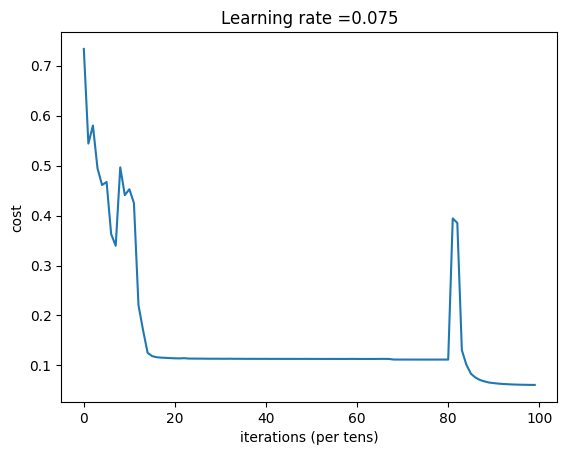

In [36]:
n_x = 12288
n_h = 7
n_y = 1
layer_dims = (n_x, n_h, n_y)
parameters = two_layer_model(train_x, train_y, layer_dims = (n_x, n_h, n_y), num_iterations = 10000, print_cost=True, isPlot=True)

## 预测

In [37]:
def predict(X, y, parameters):
    """
    该函数用于预测L层神经网络的结果，当然也包含两层

    参数：
     X - 测试集
     y - 标签
     parameters - 训练模型的参数

    返回：
     p - 给定数据集X的预测
    """
    m = X.shape[1]
    n = len(parameters) // 2 # 神经网络层数
    p = np.zeros((1,m))

    # 根据参数前向传播
    probas, caches = L_model_forward(X, parameters) # probas就是最后一层的输出值，即预测值AL
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    print("准确度为: "  + str(float(np.sum((p == y))/m)))

    return p

查看训练集和测试集的准确性

In [51]:
predictions_train = predict(train_x, train_y, parameters)
predictions_test = predict(test_x, test_y, parameters)

准确度为: 0.9952153110047847
准确度为: 0.78


搭建多层神经网络

网络结构：

<img src="./picture/img_14.png" width="100%">

In [40]:
def L_layer_model(X, Y, layer_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False, isPlot=True):
    """
    实现一个L层神经网络：[LINEAR-> RELU] *（L-1） - > LINEAR-> SIGMOID。

    参数：
	    X - 输入的数据，维度为(n_x，例子数)
        Y - 标签，向量，0为非猫，1为猫，维度为(1,数量)
        layers_dims - 层数的向量，维度为(n_y,n_h,···,n_h,n_y)
        learning_rate - 学习率
        num_iterations - 迭代的次数
        print_cost - 是否打印成本值，每100次打印一次
        isPlot - 是否绘制出误差值的图谱

    返回：
     parameters - 模型学习的参数。 然后他们可以用来预测。
    """
    np.random.seed(1)
    costs = []

    parameters = initialize_parameters_deep(layer_dims)

    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)

        # 打印成本值
        if i % 100 == 0:
            # 记录成本
            costs.append(cost)
            # 是否打印
            if print_cost:
                print("第", i, "次迭代，成本值为：", np.squeeze(cost))

    # 绘图
    if isPlot:
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

    return parameters


训练

第 0 次迭代，成本值为： 0.715731513413713
第 100 次迭代，成本值为： 0.6747377593469114
第 200 次迭代，成本值为： 0.6603365433622127
第 300 次迭代，成本值为： 0.6462887802148751
第 400 次迭代，成本值为： 0.6298131216927773
第 500 次迭代，成本值为： 0.606005622926534
第 600 次迭代，成本值为： 0.5690041263975134
第 700 次迭代，成本值为： 0.519796535043806
第 800 次迭代，成本值为： 0.46415716786282285
第 900 次迭代，成本值为： 0.40842030048298916
第 1000 次迭代，成本值为： 0.37315499216069026
第 1100 次迭代，成本值为： 0.30572374573047106
第 1200 次迭代，成本值为： 0.2681015284774083
第 1300 次迭代，成本值为： 0.23872474827672663
第 1400 次迭代，成本值为： 0.20632263257914712
第 1500 次迭代，成本值为： 0.17943886927493605
第 1600 次迭代，成本值为： 0.1579873581880168
第 1700 次迭代，成本值为： 0.1424041301227455
第 1800 次迭代，成本值为： 0.1286516599788901
第 1900 次迭代，成本值为： 0.11244314998165404
第 2000 次迭代，成本值为： 0.08505631034984254
第 2100 次迭代，成本值为： 0.05758391198617965
第 2200 次迭代，成本值为： 0.0445675345469974
第 2300 次迭代，成本值为： 0.038082751666005596
第 2400 次迭代，成本值为： 0.03441074901842194


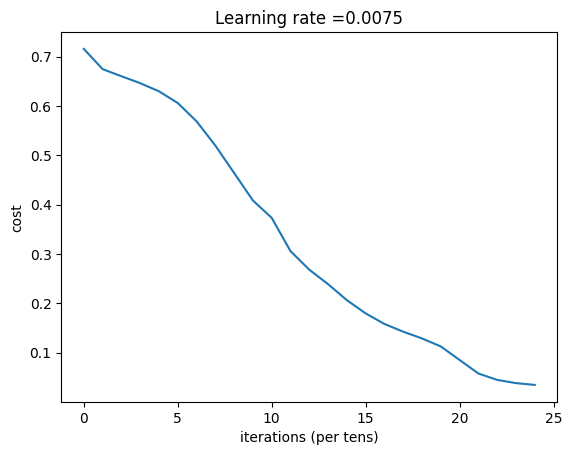

In [44]:
layers_dims = [12288, 20, 7, 5, 1] # 5层神经网络
parameters = L_layer_model(train_x, train_y, layer_dims, num_iterations = 2500, print_cost = True, isPlot = True)

## 分析
看一看有哪些东西在L层模型中被错误地标记了，导致准确率没有提高。

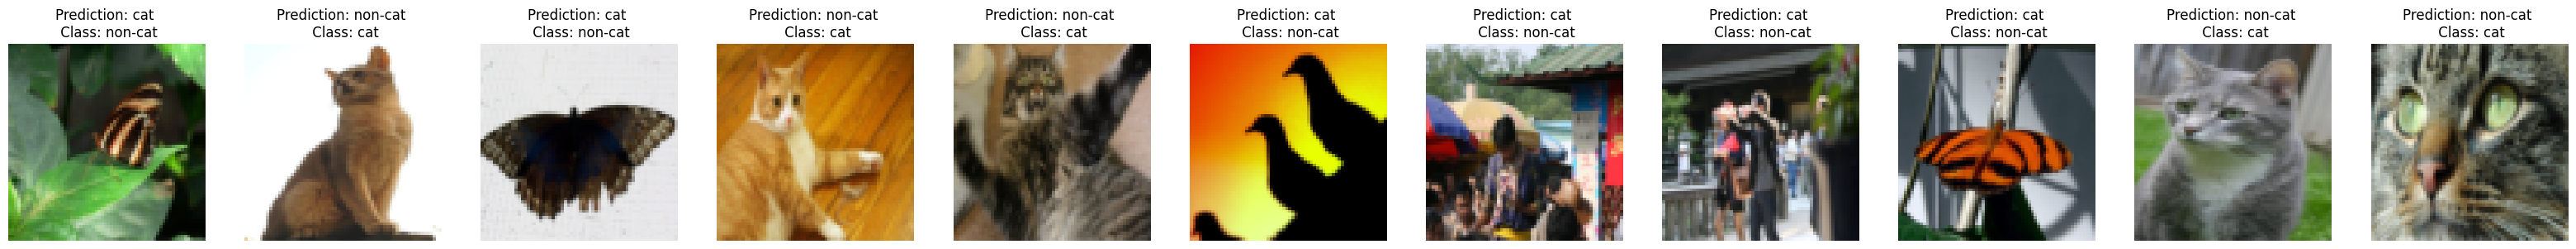

In [52]:
def print_mislabeled_images(classes, X, y, p):
    """
    绘制预测和实际 differs 的图像
    参数：
     classes - 分类器返回的所有类名
     X - 输入的图像，维度为(输入节点数量，图像数量)
     y - 实际的标签，维度为(1,image数量)
     p - 模型预测的标签，维度为(1,image数量)

    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]

        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))


# 测试
print_mislabeled_images(classes, test_x, test_y, predictions_test)


使用自己图片试试

Image shape before resizing: (2106, 3152, 4)
Image shape after resizing: (64, 64, 3)


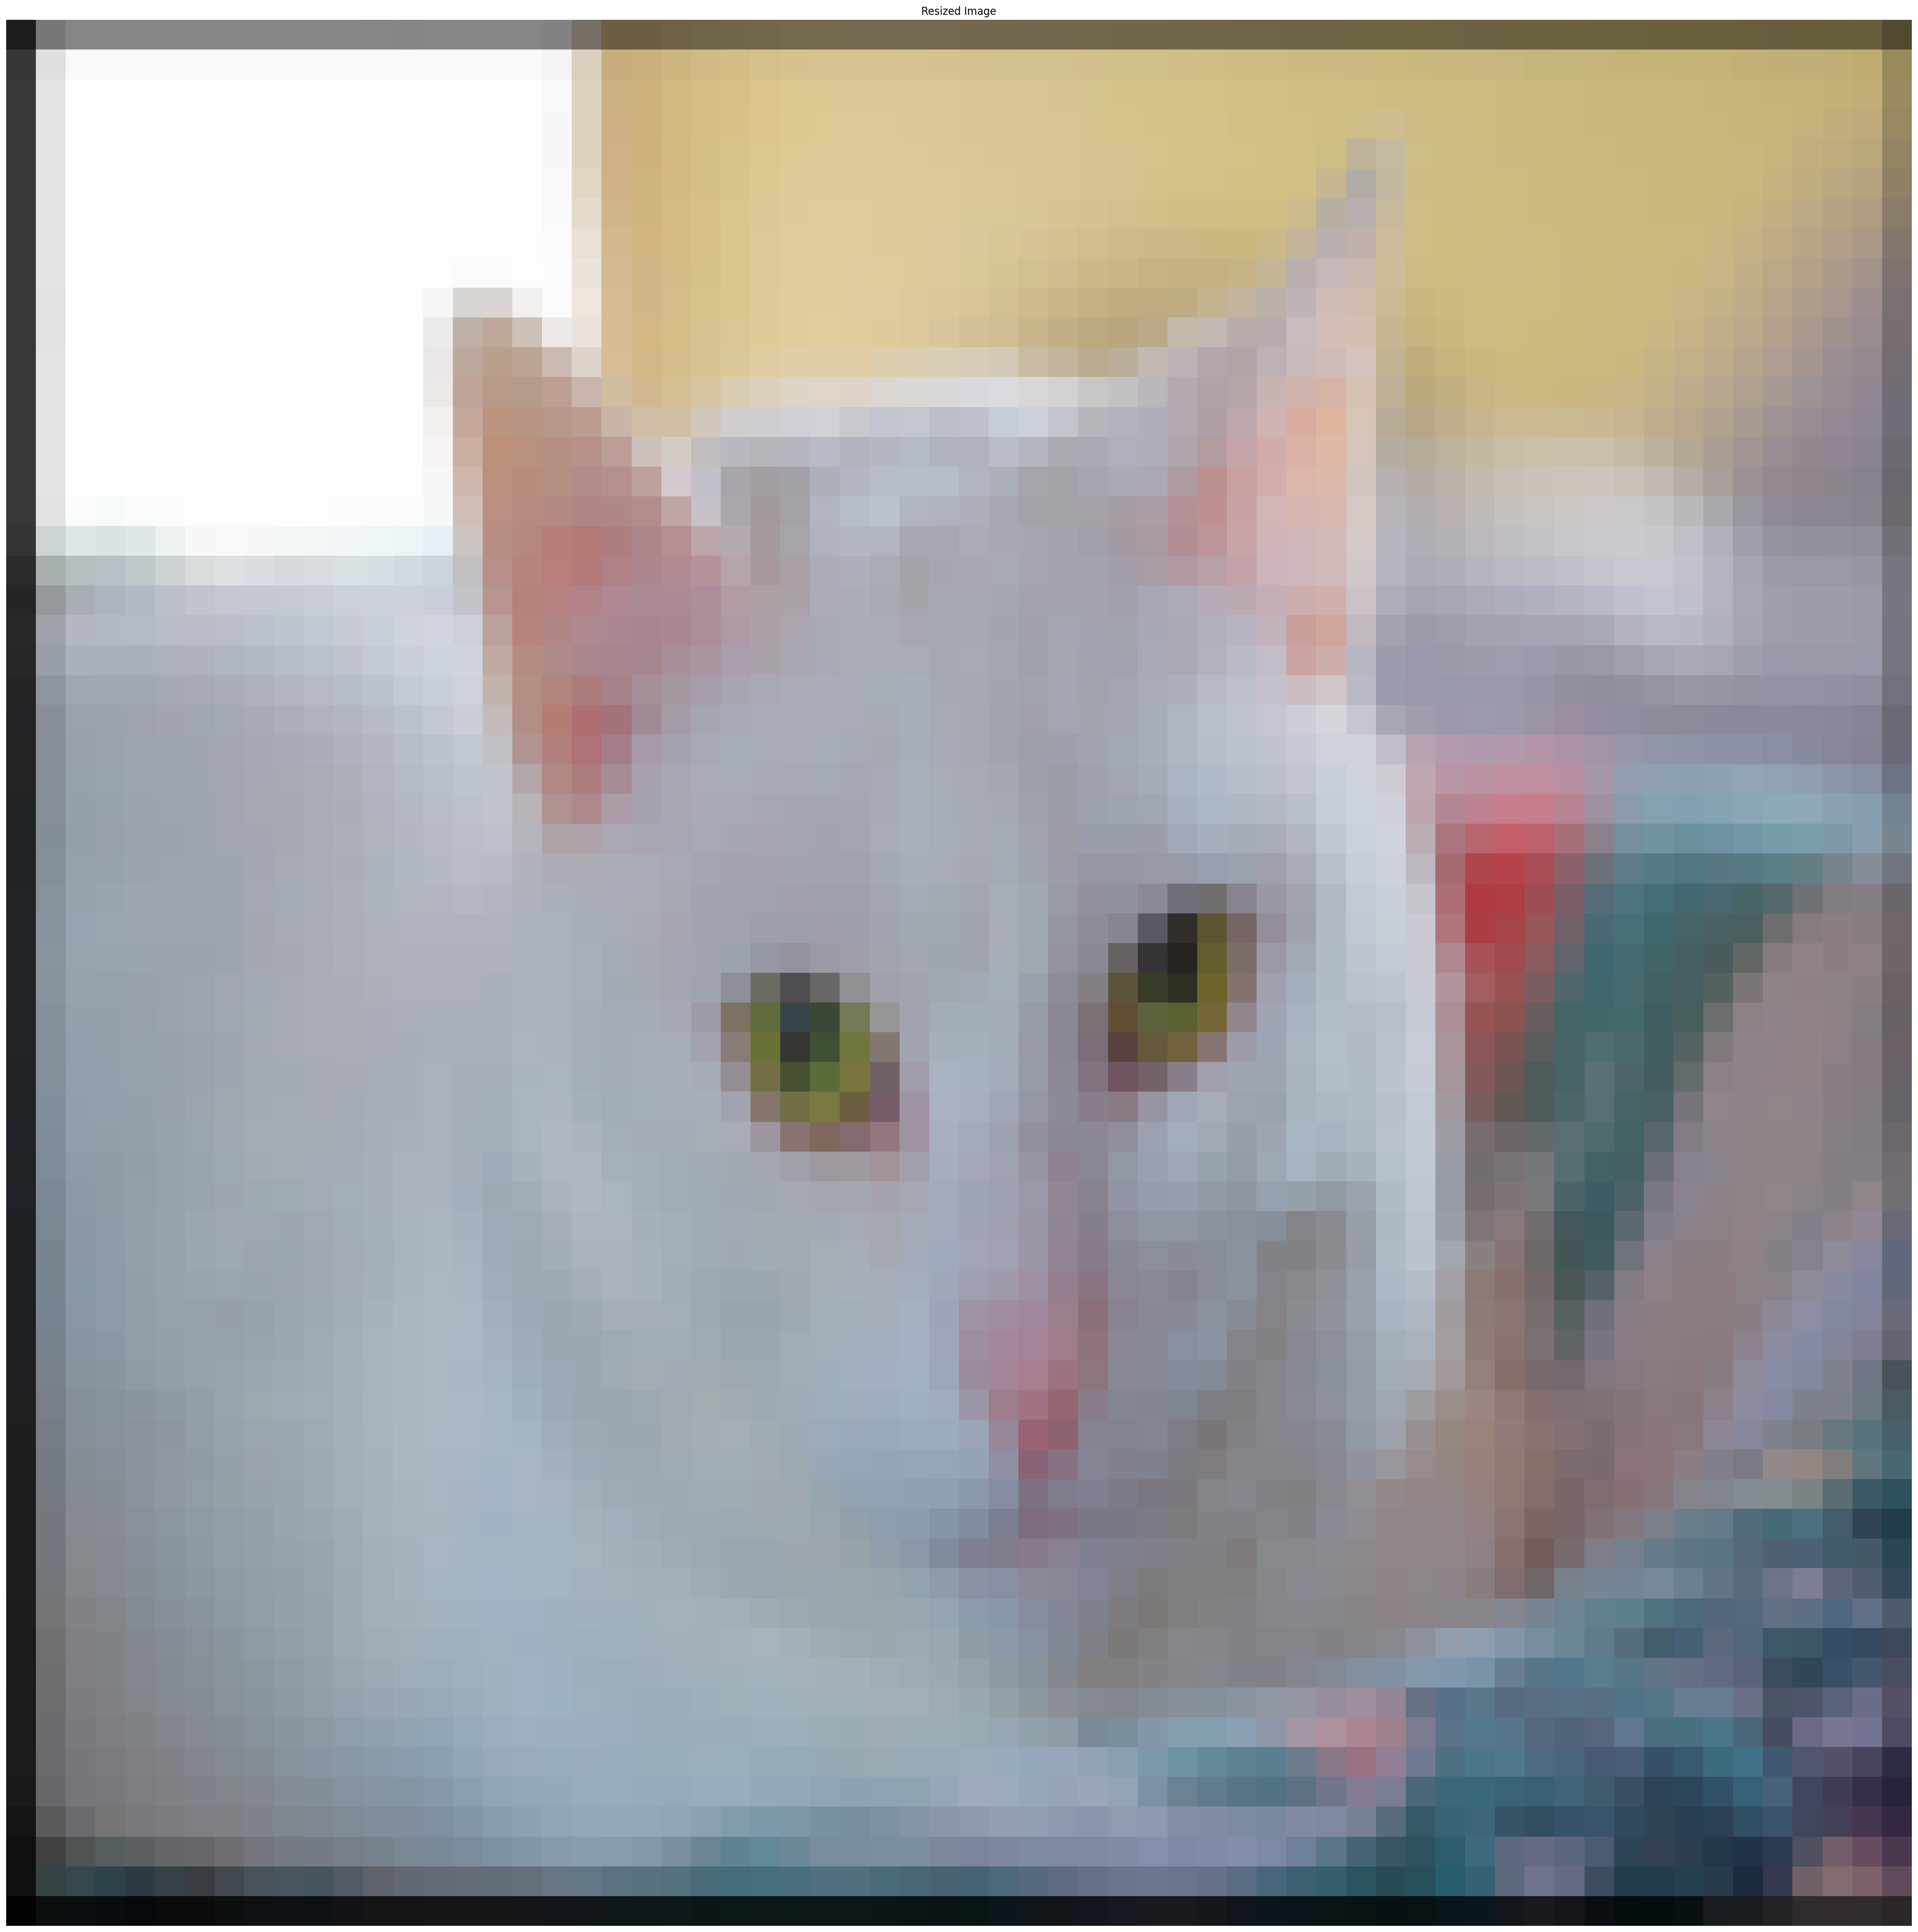

准确度为: 1.0
y = 1.0, your L-layer model predicts a "cat" picture.


In [63]:
import imageio.v2 as imageio  # 使用 imageio.v2.imread
from skimage import transform
import numpy as np
import matplotlib.pyplot as plt

## START CODE HERE ##
my_image = "./img_15.jpg"  # change this to the name of your image file
my_label_y = [1]  # the true class of your image (1 -> cat, 0 -> non-cat)
## END CODE HERE ##

# 读取图像
try:
    image = imageio.imread(my_image)
except FileNotFoundError:
    print(f"文件未找到: {my_image}")
    raise

# 检查图像尺寸
print(f"Image shape before resizing: {image.shape}")

# 如果图像有 4 个通道（RGBA），将其转换为 3 个通道（RGB）
if image.shape[2] == 4:
    image = image[:, :, :3]

# 调整图像尺寸为 64x64
image_resized = transform.resize(image, (64, 64))

# 检查调整后的图像尺寸
print(f"Image shape after resizing: {image_resized.shape}")

# 显示调整后的图像
plt.imshow(image_resized)
plt.title("Resized Image")
plt.axis('off')
plt.show()

# 重塑图像为 (12288, 1)
my_image = image_resized.reshape((64*64*3, 1))

# 进行预测
my_predicted_image = predict(my_image, my_label_y, parameters)

# 打印预测结果
print("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image))].decode("utf-8") + "\" picture.")
